### Using PyMC3 for Bayesian Analysis
I will use PyMC3 to do some Bayesian analysis. I will follow the book by Davidson-Pilon.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [23]:
txt_data = np.loadtxt('data/txtdata.csv')

In [26]:
n_txt_data = len(txt_data)
days = np.arange(n_txt_data)

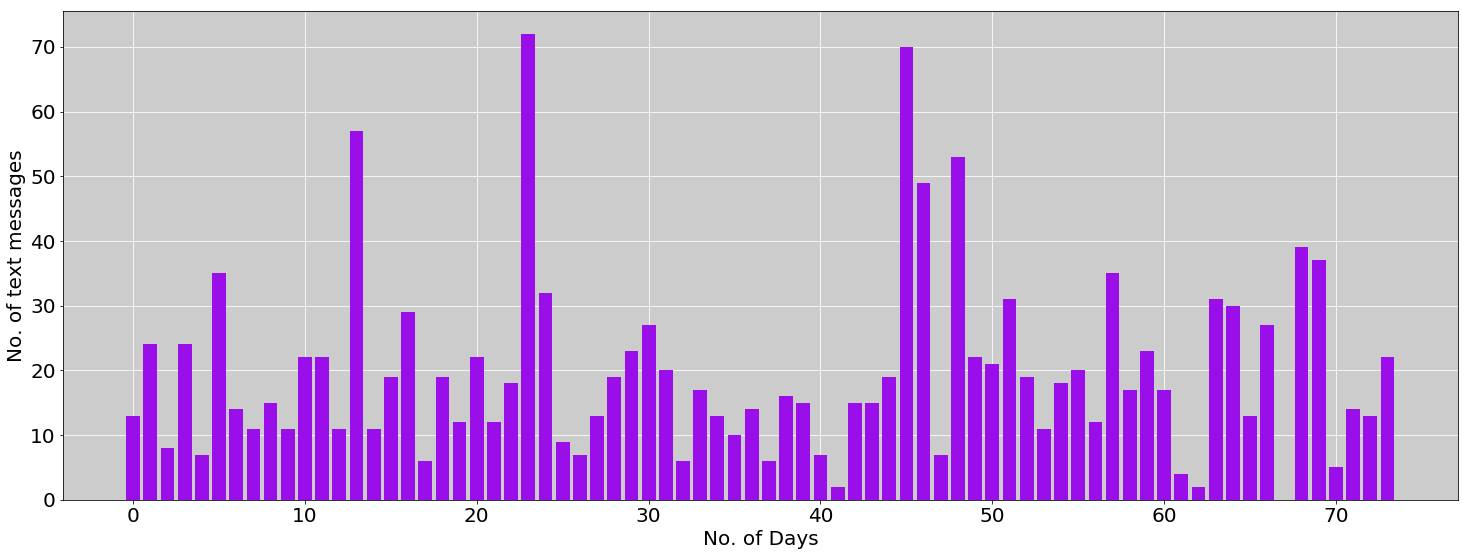

In [44]:
fig, ax = plt.subplots(1, 1, figsize = (25,9))
ax.bar(days, txt_data, color = 'xkcd:violet')
ax.set_xlabel(r'No. of Days', fontsize = 20)
ax.set_ylabel('No. of text messages', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20 )
ax.set_facecolor('0.80')
ax.grid(which = 'both', axis = 'both', color = 'xkcd:white')
ax.set_axisbelow(True)


We want to model the texting behaviour of the author over various days. Since we are counting text messages and appropriate distribution function to consider would be the Poisson distribution. However since we want to check for texting behaviour we might want to consider two different Poisson distributions to get a better understanding.

Let us denote the text message count on the $i^{th}$ day as $C_i$. Since we are couunting here we can furthermore write:

$C_i = Poisson\left(\lambda\right)$

If we assume that $\lambda$ might change after somedayy, then we can assume two values $\lambda_1$ and say after $\tau$ days we have $\lambda_2$. The specific time $\tau$ is known as the *switchpoint*. 

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

Now in order to estimate $\lambda_1$ and $\lambda_2$ using Bayesian inference we need to have a prior distribution. We know that we can use an exponential distribution function to describe non-discrete positive numbers. This exponential distribution function will have a parameter of its own. let us call this parameter $\alpha$

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}


Since the data is noisy it would be hard to decide a prior for $\tau$. We can thus consider a uniform prior in this case:

\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}


#### Using PyMC3

In [46]:
import pymc3 as pm
import theano.tensor as tt

In [49]:
with pm.Model() as model:
    alpha = 1.0/txt_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_txt_data - 1)

We can now create a function lambda_ which will allow us to switch between $\lambda_1$ and $\lambda_2$ after time $\tau$.

In [51]:
with model:
    idx = np.arange(n_txt_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

All the parameters $\lambda_1, \lambda_2, \text{ and } \tau$ are random number and so is lambda_ .

In [53]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=txt_data)

The variable `observation` combines our data, `count_data`, with our proposed data-generation scheme, given by the variable `lambda_`, through the `observed` keyword. 

The code below will be explained in Chapter 3, but I show it here so you can see where our results come from. One can think of it as a *learning* step. The machinery being employed is called *Markov Chain Monte Carlo* (MCMC), which I also delay explaining until Chapter 3. This technique returns thousands of random variables from the posterior distributions of $\lambda_1, \lambda_2$ and $\tau$. We can plot a histogram of the random variables to see what the posterior distributions look like. Below, we collect the samples (called *traces* in the MCMC literature) into histograms.

In [81]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
The number of effective samples is smaller than 25% for some parameters.


In [55]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

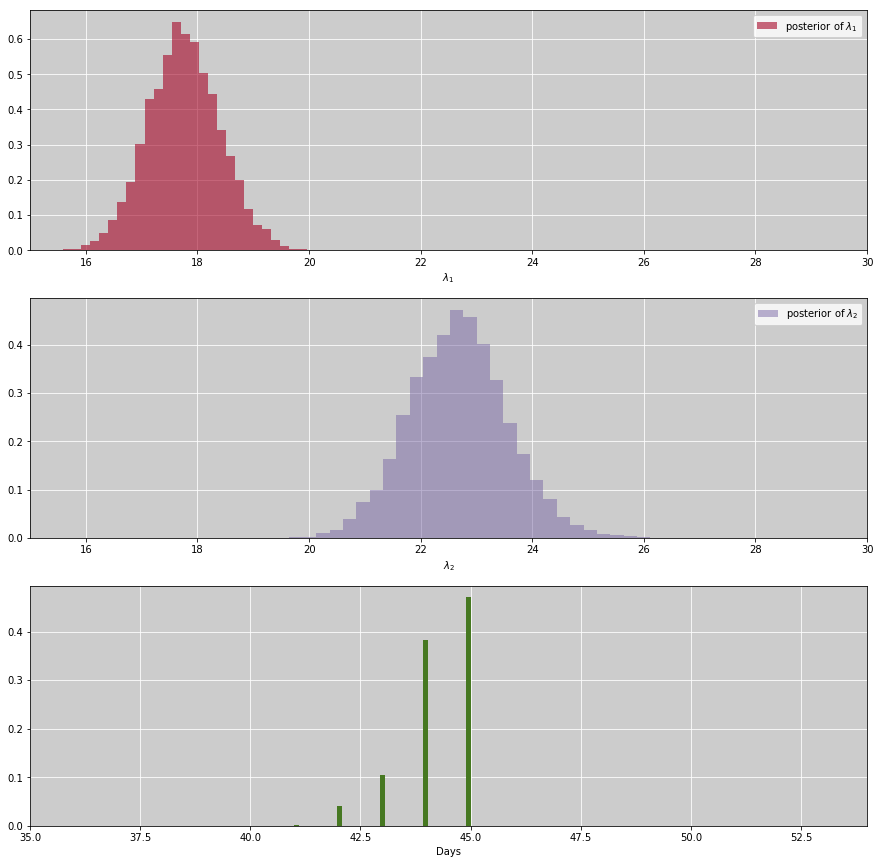

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15, 15))
ax1.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.6,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
ax1.legend(loc = 'best')
ax1.set_xlim([15, 30])
ax1.set_xlabel("$\lambda_1$")
ax1.set_facecolor('0.80')
ax1.grid(which = 'both', axis = 'both', color = 'xkcd:white')
ax1.set_axisbelow(True)
ax2.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.5,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
ax2.legend(loc='best')
ax2.set_xlim([15, 30])
ax2.set_xlabel("$\lambda_2$")
ax2.set_facecolor('0.80')
ax2.grid(which = 'both', axis = 'both', color = 'xkcd:white')
ax2.set_axisbelow(True)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
ax3.hist(tau_samples, bins=n_txt_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
ax3.set_xlim([35, len(txt_data)-20])
ax3.set_xlabel("Days")
ax3.set_facecolor('0.80')
ax3.grid(which = 'both', axis = 'both', color = 'xkcd:white')
ax3.set_axisbelow(True)

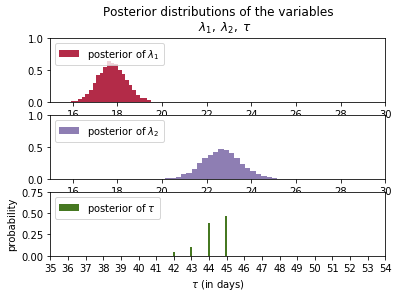

In [63]:
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_txt_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_txt_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(txt_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");